In [1]:
import pandas as pd
import json

def clean_and_normalize_data(df, normalization_range=(-1, 1)):
    
    df_processed = df.copy()
    
    original_columns = df_processed.columns.tolist()
    
    df_processed['floor'] = df_processed['floor'].replace('Bajo', '0')
    df_processed['floor'] = pd.to_numeric(df_processed['floor'], errors='coerce')
    
    df_processed['has_individual_heating'] = df_processed['has_individual_heating'].map({True: 1, False: 0})
    df_processed['has_central_heating'] = df_processed['has_central_heating'].map({True: 1, False: 0})
    
    house_types = df_processed['house_type_id'].unique().tolist()
    
    df_processed = pd.get_dummies(df_processed, columns=['house_type_id'], prefix='house_type')
    
    df_processed = df_processed.dropna()
    
    numerical_cols = ['sq_mt_built', 'sq_mt_useful', 'n_rooms', 'n_bathrooms', 
                     'floor', 'built_year', 'buy_price']
    
    normalization_info = {
        'params': {},
        'original_columns': original_columns,
        'house_types': house_types,
        'numerical_columns': numerical_cols,
        'dummy_columns': [col for col in df_processed.columns if col.startswith('house_type_')],
        'normalization_range': normalization_range
    }
    
    for col in numerical_cols:
        if col in df_processed.columns:
            min_val = df_processed[col].min()
            max_val = df_processed[col].max()
            if max_val != min_val:
                df_processed[col] = (normalization_range[0] + 
                    (df_processed[col] - min_val) * 
                    (normalization_range[1] - normalization_range[0]) / 
                    (max_val - min_val))
                normalization_info['params'][col] = {
                    'min': float(min_val),
                    'max': float(max_val),
                    'target_min': float(normalization_range[0]),
                    'target_max': float(normalization_range[1])
                }
    
    df_processed = df_processed.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df_processed, normalization_info

def save_normalization_info(normalization_info, filename):
    """
    Save normalization parameters and column information to a JSON file
    """
    with open(filename, 'w') as f:
        json.dump(normalization_info, f, indent=4)

def load_normalization_info(filename):
    """
    Load normalization parameters and column information from a JSON file
    """
    with open(filename, 'r') as f:
        return json.load(f)

def denormalize_predictions(predictions, normalization_info):
    """
    Convert predictions back to original scale
    """
    params = normalization_info['params']['buy_price']
    min_val = params['min']
    max_val = params['max']
    target_min = params['target_min']
    target_max = params['target_max']
    
    return min_val + (predictions - target_min) * (max_val - min_val) / (target_max - target_min)

def denormalize_feature(value, feature_name, normalization_info):
    """
    Denormalize a single feature value
    """
    if feature_name not in normalization_info['params']:
        return value
    
    params = normalization_info['params'][feature_name]
    return params['min'] + (value - params['target_min']) * \
           (params['max'] - params['min']) / (params['target_max'] - params['target_min'])

df = pd.read_csv('filtered_dataset.csv')

df_processed_tanh, params_tanh = clean_and_normalize_data(df, normalization_range=(-1, 1))
save_normalization_info(params_tanh, 'normalization_params_tanh.json')

df_processed_sigmoid, params_sigmoid = clean_and_normalize_data(df, normalization_range=(0, 1))
save_normalization_info(params_sigmoid, 'normalization_params_sigmoid.json')

df_processed_tanh.to_csv('processed_housing_data_tanh.csv', index=False)
df_processed_sigmoid.to_csv('processed_housing_data_sigmoid.csv', index=False)

In [13]:
class NeuralNet:
    def __init__(self, layers, epochs=1000, learning_rate=0.01, momentum=0.9, 
                 validation_split=0.2, activation='sigmoid'):
        """Initialize the neural network"""
        # Network architecture
        self.L = len(layers)
        self.n = layers.copy()
        
        # Training parameters
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.validation_split = validation_split
        self.fact = activation
        
        # Initialize arrays for activations and fields
        self.xi = [np.zeros(size, dtype=np.float64) for size in self.n]
        self.h = [np.zeros(size, dtype=np.float64) for size in self.n]
        
        # Initialize weights and thresholds with explicit dtype
        self.w = [np.zeros((1, 1), dtype=np.float64)]  # w[0] is not used
        self.theta = [np.zeros(size, dtype=np.float64) for size in self.n]
        
        # Initialize weights matrices with random values
        for l in range(1, self.L):
            limit = np.sqrt(6.0 / (self.n[l-1] + self.n[l]))
            self.w.append(np.random.uniform(-limit, limit, (self.n[l], self.n[l-1])).astype(np.float64))
        
        # Initialize arrays for backpropagation with explicit dtype
        self.delta = [np.zeros(size, dtype=np.float64) for size in self.n]
        self.d_w = [np.zeros_like(w, dtype=np.float64) for w in self.w]
        self.d_theta = [np.zeros_like(t, dtype=np.float64) for t in self.theta]
        self.d_w_prev = [np.zeros_like(w, dtype=np.float64) for w in self.w]
        self.d_theta_prev = [np.zeros_like(t, dtype=np.float64) for t in self.theta]
        
        # Arrays to store errors during training
        self.train_errors = np.zeros(epochs, dtype=np.float64)
        self.val_errors = np.zeros(epochs, dtype=np.float64)

    def activation_function(self, x, derivative=False):
        """Apply the selected activation function with numerical stability"""
        x = np.asarray(x, dtype=np.float64)
        
        if self.fact == 'sigmoid':
            if derivative:
                # Compute sigmoid
                x_safe = np.clip(x, -500, 500)  # Prevent overflow
                s = 1.0 / (1.0 + np.exp(-x_safe))
                return s * (1.0 - s)
            # Compute sigmoid
            x_safe = np.clip(x, -500, 500)  # Prevent overflow
            return 1.0 / (1.0 + np.exp(-x_safe))
        elif self.fact == 'tanh':
            if derivative:
                return 1.0 - np.power(np.tanh(x), 2)
            return np.tanh(x)
        elif self.fact == 'relu':
            if derivative:
                return np.where(x > 0, 1.0, 0.0)
            return np.maximum(0.0, x)
        else:  # linear
            if derivative:
                return np.ones_like(x, dtype=np.float64)
            return x

    def forward_propagation(self, x):
        """Implement feed-forward propagation"""
        x = np.asarray(x, dtype=np.float64)
        self.xi[0] = x
        
        for l in range(1, self.L):
            self.h[l] = np.dot(self.w[l], self.xi[l-1]) - self.theta[l]
            self.xi[l] = self.activation_function(self.h[l])
        
        return self.xi[-1]

    def backward_propagation(self, y):
        """Implement back-propagation"""
        y = np.asarray(y, dtype=np.float64)
        
        # Calculate delta for output layer
        self.delta[-1] = self.activation_function(self.h[-1], derivative=True) * (self.xi[-1] - y)
        
        # Backpropagate error
        for l in range(self.L-2, 0, -1):
            self.delta[l] = self.activation_function(self.h[l], derivative=True) * \
                           np.dot(self.w[l+1].T, self.delta[l+1])
        
        # Calculate weight and threshold changes
        for l in range(1, self.L):
            self.d_w[l] = (-self.learning_rate * np.outer(self.delta[l], self.xi[l-1]) + 
                          self.momentum * self.d_w_prev[l])
            self.d_theta[l] = (self.learning_rate * self.delta[l] + 
                              self.momentum * self.d_theta_prev[l])

    def update_parameters(self):
        """Update weights and thresholds"""
        for l in range(1, self.L):
            # Ensure arrays are float64
            self.d_w[l] = np.asarray(self.d_w[l], dtype=np.float64)
            self.d_theta[l] = np.asarray(self.d_theta[l], dtype=np.float64)
            
            # Store current changes for momentum
            self.d_w_prev[l] = self.d_w[l].copy()
            self.d_theta_prev[l] = self.d_theta[l].copy()
            
            # Apply changes
            self.w[l] = np.add(self.w[l], self.d_w[l], dtype=np.float64)
            self.theta[l] = np.add(self.theta[l], self.d_theta[l], dtype=np.float64)

    def calculate_error(self, X, y):
        """Calculate quadratic error for a set of patterns"""
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        predictions = np.array([self.forward_propagation(x) for x in X])
        return 0.5 * np.mean((predictions - y.reshape(-1, 1))**2)

    def fit(self, X, y):
        """Train the neural network"""
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        
        # Split data into training and validation sets if needed
        if self.validation_split > 0:
            split_idx = int(len(X) * (1 - self.validation_split))
            X_train, X_val = X[:split_idx], X[split_idx:]
            y_train, y_val = y[:split_idx], y[split_idx:]
        else:
            X_train, y_train = X, y
            X_val, y_val = np.array([], dtype=np.float64), np.array([], dtype=np.float64)
        
        # Training loop
        for epoch in range(self.epochs):
            # Shuffle training data
            indices = np.random.permutation(len(X_train))
            X_train = X_train[indices]
            y_train = y_train[indices]
            
            # Train on each pattern
            for i in range(len(X_train)):
                self.forward_propagation(X_train[i])
                self.backward_propagation(y_train[i])
                self.update_parameters()
            
            # Calculate and store errors
            self.train_errors[epoch] = self.calculate_error(X_train, y_train)
            if len(X_val) > 0:
                self.val_errors[epoch] = self.calculate_error(X_val, y_val)

    def predict(self, X):
        """Make predictions for the input patterns"""
        X = np.asarray(X, dtype=np.float64)
        return np.array([self.forward_propagation(x) for x in X])

    def loss_epochs(self):
        """Return the training and validation errors for each epoch"""
        return np.column_stack((self.train_errors, self.val_errors))

Loading data...

Starting hyperparameter testing...

Testing combination 1/10
Configuration: {'layers': [13, 8, 1], 'epochs': 500, 'learning_rate': 0.001, 'momentum': 0.9, 'activation': 'tanh'}
MSE: 0.0023, MAE: 0.0341, MAPE: 25.10%

Testing combination 2/10
Configuration: {'layers': [13, 16, 8, 1], 'epochs': 500, 'learning_rate': 0.001, 'momentum': 0.9, 'activation': 'tanh'}
MSE: 0.0018, MAE: 0.0302, MAPE: 25.07%

Testing combination 3/10
Configuration: {'layers': [13, 32, 16, 1], 'epochs': 500, 'learning_rate': 0.001, 'momentum': 0.9, 'activation': 'tanh'}
MSE: 0.0018, MAE: 0.0300, MAPE: 24.78%

Testing combination 4/10
Configuration: {'layers': [13, 16, 8, 1], 'epochs': 500, 'learning_rate': 0.0005, 'momentum': 0.9, 'activation': 'tanh'}
MSE: 0.0020, MAE: 0.0314, MAPE: 25.19%

Testing combination 5/10
Configuration: {'layers': [13, 16, 8, 1], 'epochs': 500, 'learning_rate': 0.001, 'momentum': 0.95, 'activation': 'tanh'}
MSE: 0.0017, MAE: 0.0295, MAPE: 25.10%

Testing combination 6/1

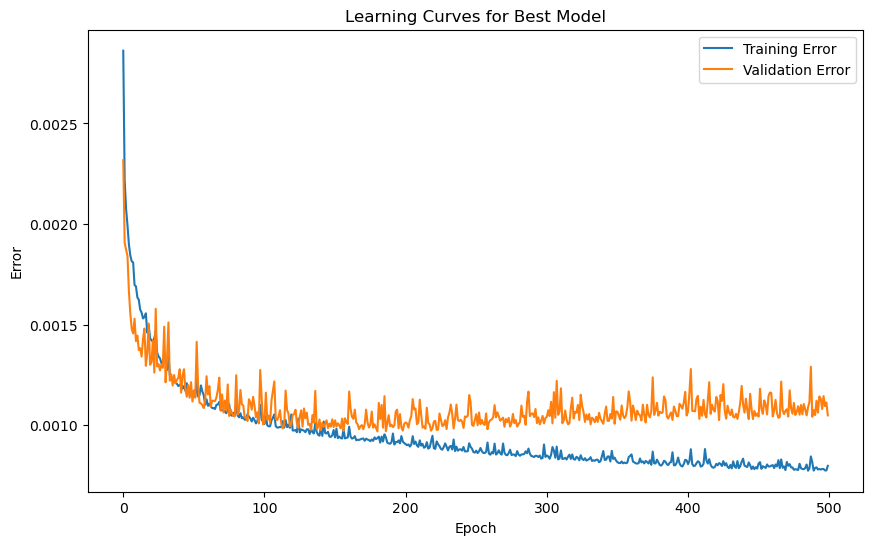


Results have been saved to 'hyperparameter_results.csv'


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, mae, mape

# Load and prepare data
df = pd.read_csv('processed_housing_data_tanh.csv')
X = df.drop('buy_price', axis=1).values
y = df['buy_price'].values

# Scale the inputs to help prevent overflow
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Some hyperparameter combinations for testing
hyperparameters = [
    {
        'layers': [X.shape[1], 8, 1],
        'epochs': 500,
        'learning_rate': 0.001,
        'momentum': 0.9,
        'activation': 'tanh'
    },
    {
        'layers': [X.shape[1], 16, 8, 1],
        'epochs': 500,
        'learning_rate': 0.001,
        'momentum': 0.9,
        'activation': 'tanh'
    },
    {
        'layers': [X.shape[1], 32, 16, 1],
        'epochs': 500,
        'learning_rate': 0.001,
        'momentum': 0.9,
        'activation': 'tanh'
    },
    {
        'layers': [X.shape[1], 16, 8, 1],
        'epochs': 500,
        'learning_rate': 0.0005,
        'momentum': 0.9,
        'activation': 'tanh'
    },
    {
        'layers': [X.shape[1], 16, 8, 1],
        'epochs': 500,
        'learning_rate': 0.001,
        'momentum': 0.95,
        'activation': 'tanh'
    },
    {
        'layers': [X.shape[1], 12, 6, 1],
        'epochs': 750,
        'learning_rate': 0.001,
        'momentum': 0.9,
        'activation': 'tanh'
    },
    {
        'layers': [X.shape[1], 16, 8, 1],
        'epochs': 500,
        'learning_rate': 0.001,
        'momentum': 0.9,
        'activation': 'sigmoid'
    },
    {
        'layers': [X.shape[1], 16, 8, 1],
        'epochs': 500,
        'learning_rate': 0.001,
        'momentum': 0.9,
        'activation': 'relu'
    },
    {
        'layers': [X.shape[1], 24, 12, 1],
        'epochs': 500,
        'learning_rate': 0.001,
        'momentum': 0.9,
        'activation': 'tanh'
    },
    {
        'layers': [X.shape[1], 16, 16, 8, 1],
        'epochs': 500,
        'learning_rate': 0.001,
        'momentum': 0.9,
        'activation': 'tanh'
    }
]

results = []

# Test each hyperparameter combination
for i, params in enumerate(hyperparameters):
    
    model = NeuralNet(
        np.array(params['layers']),
        epochs=params['epochs'],
        learning_rate=params['learning_rate'],
        momentum=params['momentum'],
        activation=params['activation']
    )
    
    model.fit(X, y)
    
    y_pred = model.predict(X)
    
    mse, mae, mape = evaluate_model(y, y_pred)
    
    # Store results
    results.append({
        'params': params,
        'metrics': {
            'mse': float(mse),
            'mae': float(mae),
            'mape': float(mape)
        },
        'errors': model.loss_epochs()
    })
    
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

# Create summary table
summary_rows = []
for i, result in enumerate(results):
    params = result['params']
    metrics = result['metrics']
    summary_rows.append({
        'Number of layers': len(params['layers']),
        'Layer Structure': '-'.join(map(str, params['layers'])),
        'Epochs': params['epochs'],
        'Learning Rate': params['learning_rate'],
        'Momentum': params['momentum'],
        'Activation': params['activation'],
        'MAPE': f"{metrics['mape']:.2f}%",
        'MAE': f"{metrics['mae']:.4f}",
        'MSE': f"{metrics['mse']:.4f}"
    })

summary_df = pd.DataFrame(summary_rows)

# Find best model based on MSE
best_model_idx = min(range(len(results)), 
                    key=lambda i: results[i]['metrics']['mse'])
best_result = results[best_model_idx]

print(f"\nBest model (combination {best_model_idx + 1}):")
for key, value in best_result['params'].items():
    print(f"{key}: {value}")

# Plot training curves for best model
errors = best_result['errors']
plt.figure(figsize=(10, 6))
plt.plot(errors[:, 0], label='Training Error')
plt.plot(errors[:, 1], label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Learning Curves for Best Model')
plt.legend()
plt.show()

summary_df.to_csv('hyperparameter_results.csv', index=False)

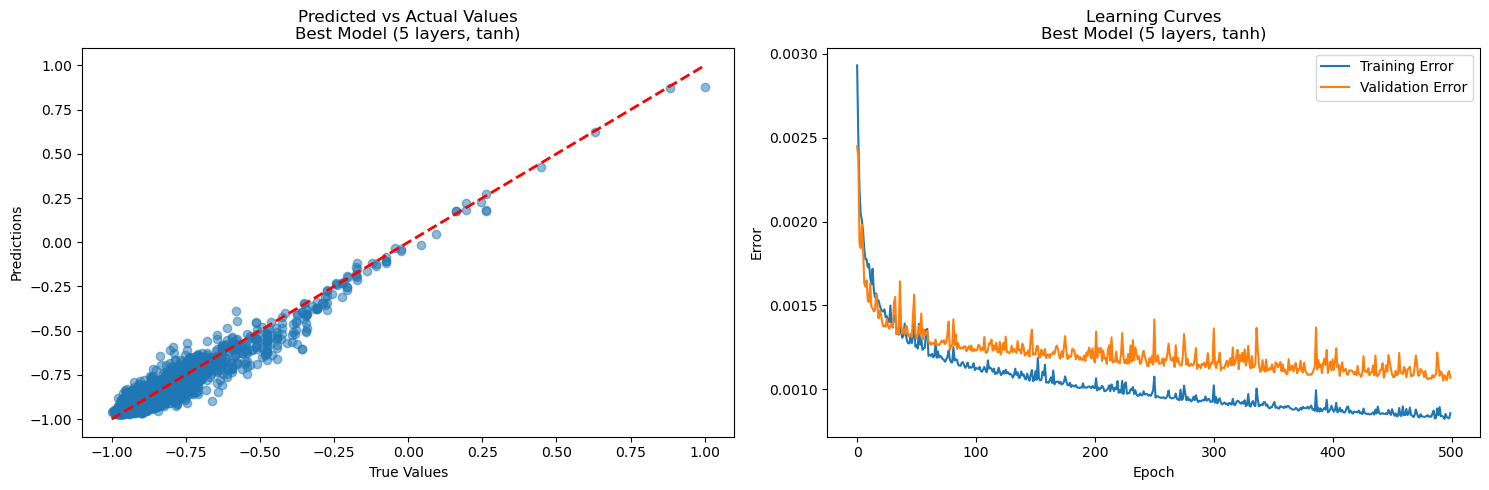

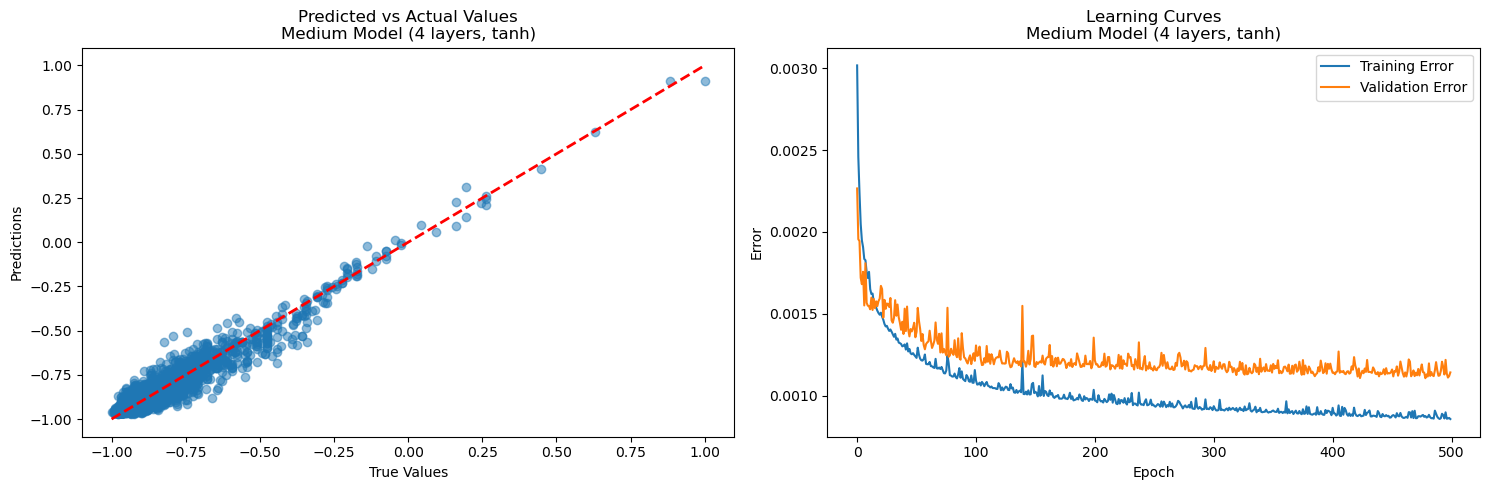

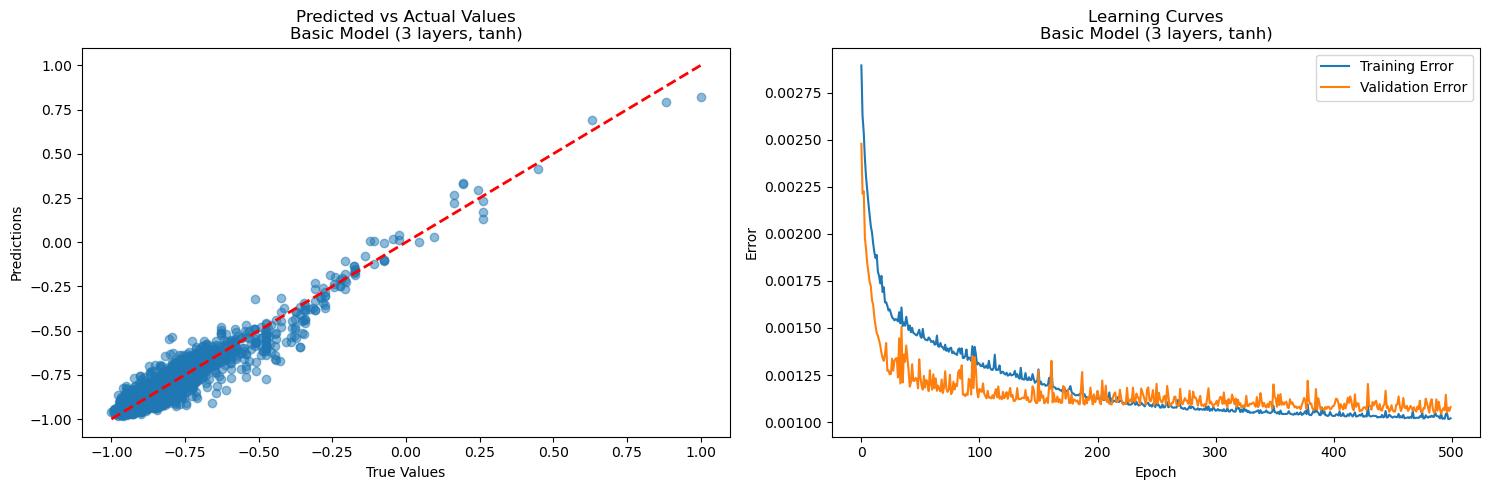

In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('processed_housing_data_tanh.csv')
X = df.drop('buy_price', axis=1).values
y = df['buy_price'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

def train_model(layers, epochs, learning_rate, momentum, activation):
    model = NeuralNet(
        np.array(layers),
        epochs=epochs,
        learning_rate=learning_rate,
        momentum=momentum,
        activation=activation
    )
    model.fit(X, y)
    return model

def plot_model_results(model, y, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Scatter plot
    y_pred = model.predict(X)
    ax1.scatter(y, y_pred, alpha=0.5)
    ax1.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    ax1.set_xlabel('True Values')
    ax1.set_ylabel('Predictions')
    ax1.set_title(f'Predicted vs Actual Values\n{title}')
    
    # Learning curves
    errors = model.loss_epochs()
    ax2.plot(errors[:, 0], label='Training Error')
    ax2.plot(errors[:, 1], label='Validation Error')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Error')
    ax2.set_title(f'Learning Curves\n{title}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Plot results for best model from prev testing (5 layers)
best_model = train_model(
    layers=[13, 16, 16, 8, 1],
    epochs=500,
    learning_rate=0.001,
    momentum=0.9,
    activation='tanh'
)
plot_model_results(best_model, y, 'Best Model (5 layers, tanh)')

# Plot results for arbitrary medium model from prev testing (4 layers)
medium_model = train_model(
    layers=[13, 16, 8, 1],
    epochs=500,
    learning_rate=0.001,
    momentum=0.9,
    activation='tanh'
)
plot_model_results(medium_model, y, 'Medium Model (4 layers, tanh)')

# Plot results for basic model from prev testing (3 layers)
basic_model = train_model(
    layers=[13, 8, 1],
    epochs=500,
    learning_rate=0.001,
    momentum=0.9,
    activation='tanh'
)
plot_model_results(basic_model, y, 'Basic Model (3 layers, tanh)')

Loading data...

Training BP model...

BP (Your Implementation) Results:
MSE: 0.001788
MAE: 0.029667
MAPE: 25.43%


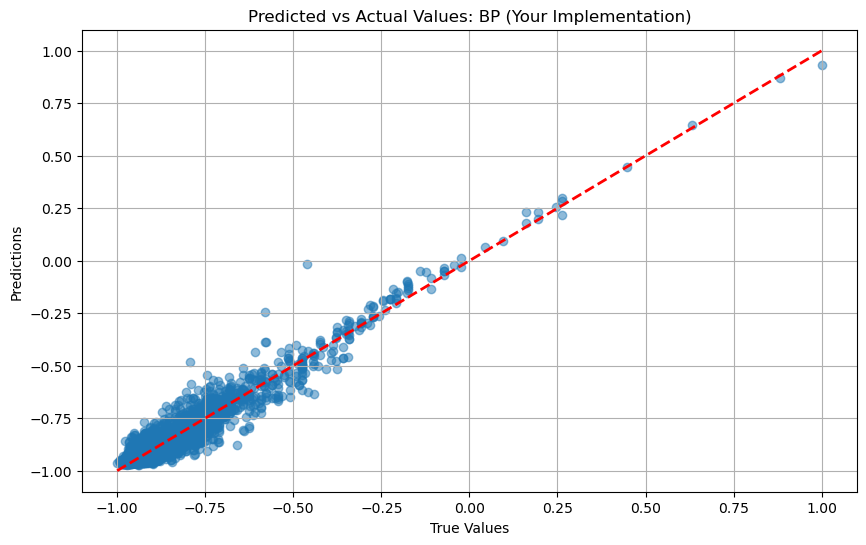


Training MLR-F model...

MLR-F (scikit-learn) Results:
MSE: 0.003838
MAE: 0.039342
MAPE: 7.14%


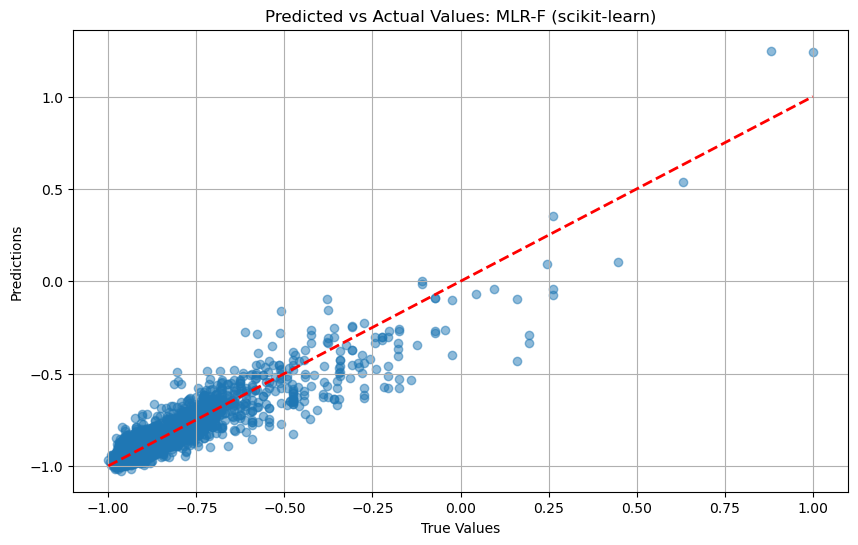


Training BP-F model...


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

class TorchNN(nn.Module):
    def __init__(self, input_size):
        super(TorchNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 8),
            nn.Tanh(),
            nn.Linear(8, 1)
        )
    
    def forward(self, x):
        return self.network(x)

df = pd.read_csv('processed_housing_data_tanh.csv')
X = df.drop('buy_price', axis=1).values
y = df['buy_price'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"\n{model_name} Results:")
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"MAPE: {mape:.2f}%")
    return mse, mae, mape

def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'Predicted vs Actual Values: {title}')
    plt.grid(True)
    plt.show()

bp_model = NeuralNet(
    np.array([X.shape[1], 16, 16, 8, 1]),
    epochs=500,
    learning_rate=0.001,
    momentum=0.9,
    activation='tanh'
)
bp_model.fit(X_scaled, y)
bp_predictions = bp_model.predict(X_scaled)
bp_metrics = evaluate_model(y, bp_predictions, "BP (My Implementation)")
plot_predictions(y, bp_predictions, "BP (My Implementation)")

mlr_model = LinearRegression()
mlr_model.fit(X_scaled, y)
mlr_predictions = mlr_model.predict(X_scaled)
mlr_metrics = evaluate_model(y, mlr_predictions, "MLR-F (scikit-learn)")
plot_predictions(y, mlr_predictions, "MLR-F (scikit-learn)")

X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y.reshape(-1, 1))

torch_model = TorchNN(X.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(torch_model.parameters(), lr=0.001)

n_epochs = 500
for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = torch_model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

torch_model.eval()
with torch.no_grad():
    torch_predictions = torch_model(X_tensor).numpy().flatten()
torch_metrics = evaluate_model(y, torch_predictions, "BP-F (PyTorch)")
plot_predictions(y, torch_predictions, "BP-F (PyTorch)")

results_df = pd.DataFrame({
    'Model': ['BP (My Implementation)', 'MLR-F (scikit-learn)', 'BP-F (PyTorch)'],
    'MSE': [bp_metrics[0], mlr_metrics[0], torch_metrics[0]],
    'MAE': [bp_metrics[1], mlr_metrics[1], torch_metrics[1]],
    'MAPE (%)': [bp_metrics[2], mlr_metrics[2], torch_metrics[2]]
})

print(results_df.to_string(index=False))

results_df.to_csv('model_comparison_results.csv', index=False)